In [1]:
import pandas as pd
import keras
import numpy as np
import sys
sys.path.append('../')
from src.models import combined_cnn
from src.generator import generator_two_inputs
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [2]:
# import dataframe with filenames and labels
sample = pd.read_csv('../labels/training_labels_updated.csv')
sample['temp_label'] = sample['final_label'].apply(lambda x: np.round(x))

In [3]:
sample['temp_label'] = sample['temp_label'].astype('int').astype('str')
train_data, test_data = train_test_split(sample, test_size = 0.25, random_state = 100)

In [4]:
sample.head()

,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,GSV_Driveway,final_label,aerial_filename,gsv_filename,temp_label
0,1,ESSEX ST,50-B-12,"1 ESSEX ST, SOMERVILLE, MA",2,1,0.9,1_ESSEX_ST_aerial.png,1_ESSEX_ST.jpg,1
1,1,PACKARD AVE,11-E-29,"1 PACKARD AVE, SOMERVILLE, MA",2,1,0.9,1_PACKARD_AVE_aerial.png,1_PACKARD_AVE.jpg,1
2,1,THURSTON ST,50-A-9,"1 THURSTON ST, SOMERVILLE, MA",1,2,0.9,1_THURSTON_ST_aerial.png,1_THURSTON_ST.jpg,1
3,1,WEBSTER ST,91-B-14,"1 WEBSTER ST, SOMERVILLE, MA",1,1,1.0,1_WEBSTER_ST_aerial.png,1_WEBSTER_ST.jpg,1
4,3,AVON ST,51-E-30,"3 AVON ST, SOMERVILLE, MA",1,1,1.0,3_AVON_ST_aerial.png,3_AVON_ST.jpg,1


In [ ]:
train_data.groupby('temp_label').aggregate({'ADDR_NUM':len})

^ clearly there's an imbalanced class problem

In [6]:
# input parameters
batch_size = 8
epochs = 5

In [7]:
model = combined_cnn()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gsv_image_input (InputLayer)    (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 638, 638, 128 3584        gsv_image_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 319, 319, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 317, 317, 64) 73792       max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

In [10]:
#implement class weights as an easy first attempt to handle imbalanced class problem
class_weight = {1: 0.45,
                0: 0.55}

In [ ]:
history = model.fit_generator(
                # train 
                generator_two_inputs(train_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                gsv_image_dim = (640, 640, 3), aer_image_dim = ((2100, 2100, 4))),
    
                validation_data=generator_two_inputs(test_data, aerial_dir = '../data/training/aerial_images/', 
                gsv_dir ='data/training/street_view_images/', batch_size = batch_size, 
                gsv_image_dim = (640, 640, 3), aer_image_dim = ((2100, 2100, 4))),
                validation_steps = 2,
                steps_per_epoch=np.ceil(sample.shape[0]//batch_size), 
                epochs=epochs,class_weight = class_weight,
                verbose=1)

Found 215 validated image filenames belonging to 2 classes.Epoch 1/5

Found 215 validated image filenames belonging to 2 classes.
 9/35 [======>.......................] - ETA: 9:02 - loss: 3.9101 - acc: 0.7431 - sensitivity: 0.7361 - specificity: 0.7500

In [9]:
history.params['metrics']

['loss', 'acc', 'val_loss', 'val_acc']

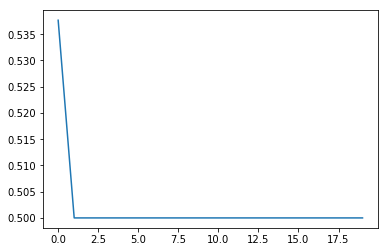

In [12]:
plt.plot(history.history['acc'])

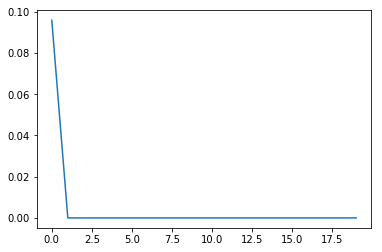

In [16]:
plt.plot(history.history['specificity'])

In [14]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_sensitivity', 'val_specificity', 'loss', 'acc', 'sensitivity', 'specificity'])

In [ ]:
his